In [1]:
import sys
sys.path.insert(0, "..")
from pathlib import Path
import re
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
from matplotlib.container import BarContainer
from matplotlib.ticker import FuncFormatter

def comma_formatter(x, pos):
    return f'{x:,.0f}'

def pretty_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

BENCHMARK_NAME="ior-strided"
FIG_DIR = Path(f"../../fig/{BENCHMARK_NAME}").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
def save(fig, name):
    for ext in ('png', 'eps'):
        fig.savefig(FIG_DIR / f'{name}.{ext}', bbox_inches = 'tight')
    # pass 


In [2]:
def load_ior_summary_list(json_file: Path):
    data = json.loads(json_file.read_text())
    return [
        {
            'Version': data['Version'],
            'Began': data['Began'],
            'Command line': data['Command line'],
            'Machine': data['Machine'],
            'Finished': data['Finished'],
            **{f'test_{k}': v for k, v in test.items() if k not in ["Results", "max", "Parameters", "Options"]},
            **{f"max_{k}": v for k, v in test["max"].items()},
            **{f"Parameters_{k}": v for k, v in test["Parameters"].items()},
            **{f"Options_{k}": v for k, v in test["Options"].items()},
            **{f'summary_{k}': v for k, v in data['summary'][index].items()},
            **{f'result_{k}': v for k, v in result.items()},
            'iorIteration': iteration,
        }
        for index, test in enumerate(data['tests'])
        for iteration, results in enumerate(test["Results"]) # iteration ?
        for result in results
    ]
# load_ior_summary_list(Path(f"../raw/{BENCHMARK_NAME}/2023.11.16-19.27.41/2023.11.16-20.03.19-92963.nqsv-bank-conflict-1/ior_summary_1.json"))


In [3]:
re_hook_pmembb = re.compile(r"hook:pmembb:rpmbb_store_(create|free|save|load) ([0-9]+\.[0-9]+)")
def df_extract_hook_pmembb_time(stderr_path: Path):
    text = stderr_path.read_text()
    matches = re_hook_pmembb.findall(text)
    return pd.DataFrame(matches, columns=["type", "time"])

def extract_hook_pmembb_time_max(stderr_path: Path):
    return (
        df_extract_hook_pmembb_time(stderr_path)
        .groupby("type")
        .max()
        .transpose()
        .rename(columns={
            "create": "createTime",
            "free": "freeTime",
            "save": "saveTime",
            "load": "loadTime",
        })
        .reset_index(drop=True)
        .astype(float)
        .loc[0,:]
        .to_dict()
    )

wpath = Path("../../raw/ior-pmembb/2024.01.23-15.22.18-default/2024.01.23-15.24.03-166930.nqsv-1/ior_stderr_8.txt")
rpath = Path("../../raw/ior-pmembb/2024.01.23-15.22.18-default/2024.01.23-15.24.03-166930.nqsv-1/ior_stderr_8.txt")
extract_hook_pmembb_time_max(rpath)


{'createTime': 14.976, 'freeTime': 0.023, 'loadTime': 0.005}

In [4]:
RAW_BASEDIR=Path(f"../../raw/")

default_metadata={
}

job_group = (
    # ("ior-strided-pmembb/2024.02.06-16.16.59-default", {}),
    # ("ior-strided-pmembb/2024.02.06-16.17.48-default", {}),
    ("ior-strided-pmembb/2024.02.07-11.48.42-default", {}),
    ("ior-strided-pmembb/2024.02.07-11.51.58-default", {}),
)

def job_dirs(job_group_dir: str):
    dir = RAW_BASEDIR / job_group_dir
    return (f.resolve() for f in dir.iterdir() if f.is_dir())

re_timestamp = re.compile(r'([0-9]{4})\.([0-9]{2})\.([0-9]{2})-([0-9]{2})\.([0-9]{2})\.([0-9]{2})')
def parse_job_start_timestamp(job_dir: Path):
    m = re_timestamp.search(str(job_dir))
    if m:
        return m.group()
    else:
        return None

re_runid = re.compile(r"_([0-9]+)\.json")
def get_runid(file: Path):
    m = re_runid.search(str(file))
    if m:
        return int(m.group(1))
    else:
        return None

def load_nodelist(job_dir: Path):
    with(job_dir / f"nodelist").open() as f:
        return list(map(lambda s: s.strip(), f.readlines()))

src = []
for job_group_dir,metadata in job_group:
    for job_dir in job_dirs(job_group_dir):
        try:
            job_start = {"job_start": parse_job_start_timestamp(job_dir)}
            job_nodelist = {"nodelist": load_nodelist(job_dir)}
        except Exception as e:
            print(f"{job_dir}, {e}")
        for summary_file in job_dir.glob("ior_summary_*.json"):
            try:
                runid = get_runid(summary_file)
                job_summary_list = load_ior_summary_list(summary_file)
                job_params_file = job_dir / f"job_params_{runid}.json"
                job_params = json.loads(job_params_file.read_text())
                pmembb_time = extract_hook_pmembb_time_max(job_dir / f"ior_stderr_{runid}.txt")
                for job_summary in job_summary_list:
                    src.append({
                        **default_metadata,
                        **metadata,
                        **job_start,
                        **job_nodelist,
                        **job_params,
                        **job_summary,
                        **pmembb_time,
                        "runid": runid,
                    })
            except FileNotFoundError as e:
                print(e)
            except Exception as e:
                print(f'{summary_file}, {e}')

df_src = (
    pd.DataFrame(src)
    .assign(odirect=lambda x: x["Command line"].str.contains("--posix.odirect"))
    .assign(strided=lambda x: x["summary_transferSize"] == x["summary_blockSize"])
    .rename({
        "summary_bwMaxMIB": "bw",
        "summary_MeanTime": "time",
        "summary_segmentCount": "segmentCount",
        "summary_blockSize": "blockSize",
        "summary_transferSize": "transferSize",
        "summary_operation": "operation",
        "Parameters_filePerProc": "fpp",
        "Parameters_reorderTasks": "reorder",
        "summary_API": "api",
        "result_access": "access",
        "result_bwMiB": "bwMiB",
        "result_openTime": "openTime",
        "result_wrRdTime": "wrRdTime",
        "result_closeTime": "closeTime",
        "result_totalTime": "totalTime",
    }, axis=1)
    .astype({"fpp": bool, "reorder": bool,})
    .assign(bwGB=lambda x: x["bwMiB"] * 2**20 / 10**9)
)
df_src["label"] = np.select([
    (df_src["access"] == "write"),
    (df_src["access"] == "read") & (df_src["reorder"] == True) & (df_src["segmentCount"] > 256),
    (df_src["access"] == "read") & (df_src["reorder"] == False) & (df_src["segmentCount"] > 256),
    (df_src["access"] == "read") & (df_src["reorder"] == False) & (df_src["segmentCount"] <= 256),
], ["Strided Write", "Strided Read (remote)", "Strided Read (local)", "Segmented Read"])


df_src.head()


,job_start,nodelist,nnodes,ppn,np,jobid,runid,pmem_path,pmem_size,lustre_version,...,freeTime,saveTime,max_readMiB,max_readMB,Options_task offset,loadTime,odirect,strided,bwGB,label
0,2024.02.07-11.48.42,"[bnode115, bnode116, bnode117, bnode118]",4,8,32,170268.nqsv,0,/dev/dax0.0,0,2.12.9_ddn38,...,0.311,0.676,NaN,NaN,NaN,NaN,False,True,68.239813,Strided Write
1,2024.02.07-11.48.42,"[bnode115, bnode116, bnode117, bnode118]",4,8,32,170268.nqsv,1,/dev/dax0.0,0,2.12.9_ddn38,...,0.352,NaN,6275.7784,6580.6306,1.0,2.855,False,True,6.580631,Strided Read (remote)
2,2024.02.07-11.48.42,"[bnode115, bnode116, bnode117, bnode118]",4,8,32,170268.nqsv,3,/dev/dax0.0,0,2.12.9_ddn38,...,0.346,NaN,53205.1121,55789.6037,NaN,2.773,False,False,55.789604,Segmented Read
3,2024.02.07-11.48.42,"[bnode115, bnode116, bnode117, bnode118]",4,8,32,170268.nqsv,2,/dev/dax0.0,0,2.12.9_ddn38,...,0.356,NaN,31415.5904,32941.6341,NaN,2.778,False,True,32.941634,Strided Read (local)
4,2024.02.07-11.48.42,"[bnode017, bnode018, bnode019, bnode020, bnode...",8,8,64,170270.nqsv,0,/dev/dax0.0,0,2.12.9_ddn38,...,0.884,1.161,NaN,NaN,NaN,NaN,False,True,133.726090,Strided Write


In [5]:
df = df_src

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# display(df.columns.to_list())

(
    df[[
        "spack_env_name",
        "nnodes",
        "np",
        "segmentCount",
        "blockSize",
        "transferSize",
        "lustre_stripe_count",
        "api",
        "label",
        "access",
        "reorder",
        "bwGB",
        "openTime",
        "wrRdTime",
        "closeTime",
        "totalTime",
        "createTime",
        "freeTime",
        "loadTime",
        "saveTime",
        "loadTime",
    ]]
    # .head()
)


,spack_env_name,nnodes,np,segmentCount,blockSize,transferSize,lustre_stripe_count,api,label,access,reorder,bwGB,openTime,wrRdTime,closeTime,totalTime,createTime,freeTime,loadTime,saveTime,loadTime
0,mpiio-pmembb,4,32,262144,1024,1024,1,MPIIO,Strided Write,write,False,68.239813,0.0051,0.1205,0.0002,0.1259,4.528,0.311,NaN,0.676,NaN
1,mpiio-pmembb,4,32,262144,1024,1024,1,MPIIO,Strided Read (remote),read,True,6.580631,0.0029,1.3020,0.0003,1.3053,4.503,0.352,2.855,NaN,2.855
2,mpiio-pmembb,4,32,1,268435456,1048576,1,MPIIO,Segmented Read,read,False,55.789604,0.0054,0.1482,0.0003,0.1540,4.510,0.346,2.773,NaN,2.773
3,mpiio-pmembb,4,32,262144,1024,1024,1,MPIIO,Strided Read (local),read,False,32.941634,0.0055,0.2549,0.0003,0.2608,4.543,0.356,2.778,NaN,2.778
4,mpiio-pmembb,8,64,262144,1024,1024,1,MPIIO,Strided Write,write,False,133.726090,0.0058,0.1224,0.0003,0.1285,4.509,0.884,NaN,1.161,NaN
5,mpiio-pmembb,8,64,262144,1024,1024,1,MPIIO,Strided Read (remote),read,True,12.505586,0.0030,1.3705,0.0003,1.3738,4.472,0.695,5.930,NaN,5.930
6,mpiio-pmembb,8,64,1,268435456,1048576,1,MPIIO,Segmented Read,read,False,118.771079,0.0069,0.1373,0.0004,0.1446,4.486,0.714,6.240,NaN,6.240
7,mpiio-pmembb,8,64,262144,1024,1024,1,MPIIO,Strided Read (local),read,False,54.528428,0.0059,0.3089,0.0002,0.3151,4.489,0.826,5.913,NaN,5.913
8,mpiio-pmembb-deferred-open,1,8,262144,1024,1024,1,MPIIO,Strided Write,write,False,14.403031,0.0030,0.1460,0.0002,0.1491,4.520,0.056,NaN,0.124,NaN
9,mpiio-pmembb-deferred-open,1,8,262144,1024,1024,1,MPIIO,Strided Read (remote),read,True,11.373791,0.0023,0.1863,0.0002,0.1888,4.448,0.076,0.603,NaN,0.603


<Axes: xlabel='spack_env_name,nnodes,access,reorder,label,transferSize,lustre_stripe_count'>

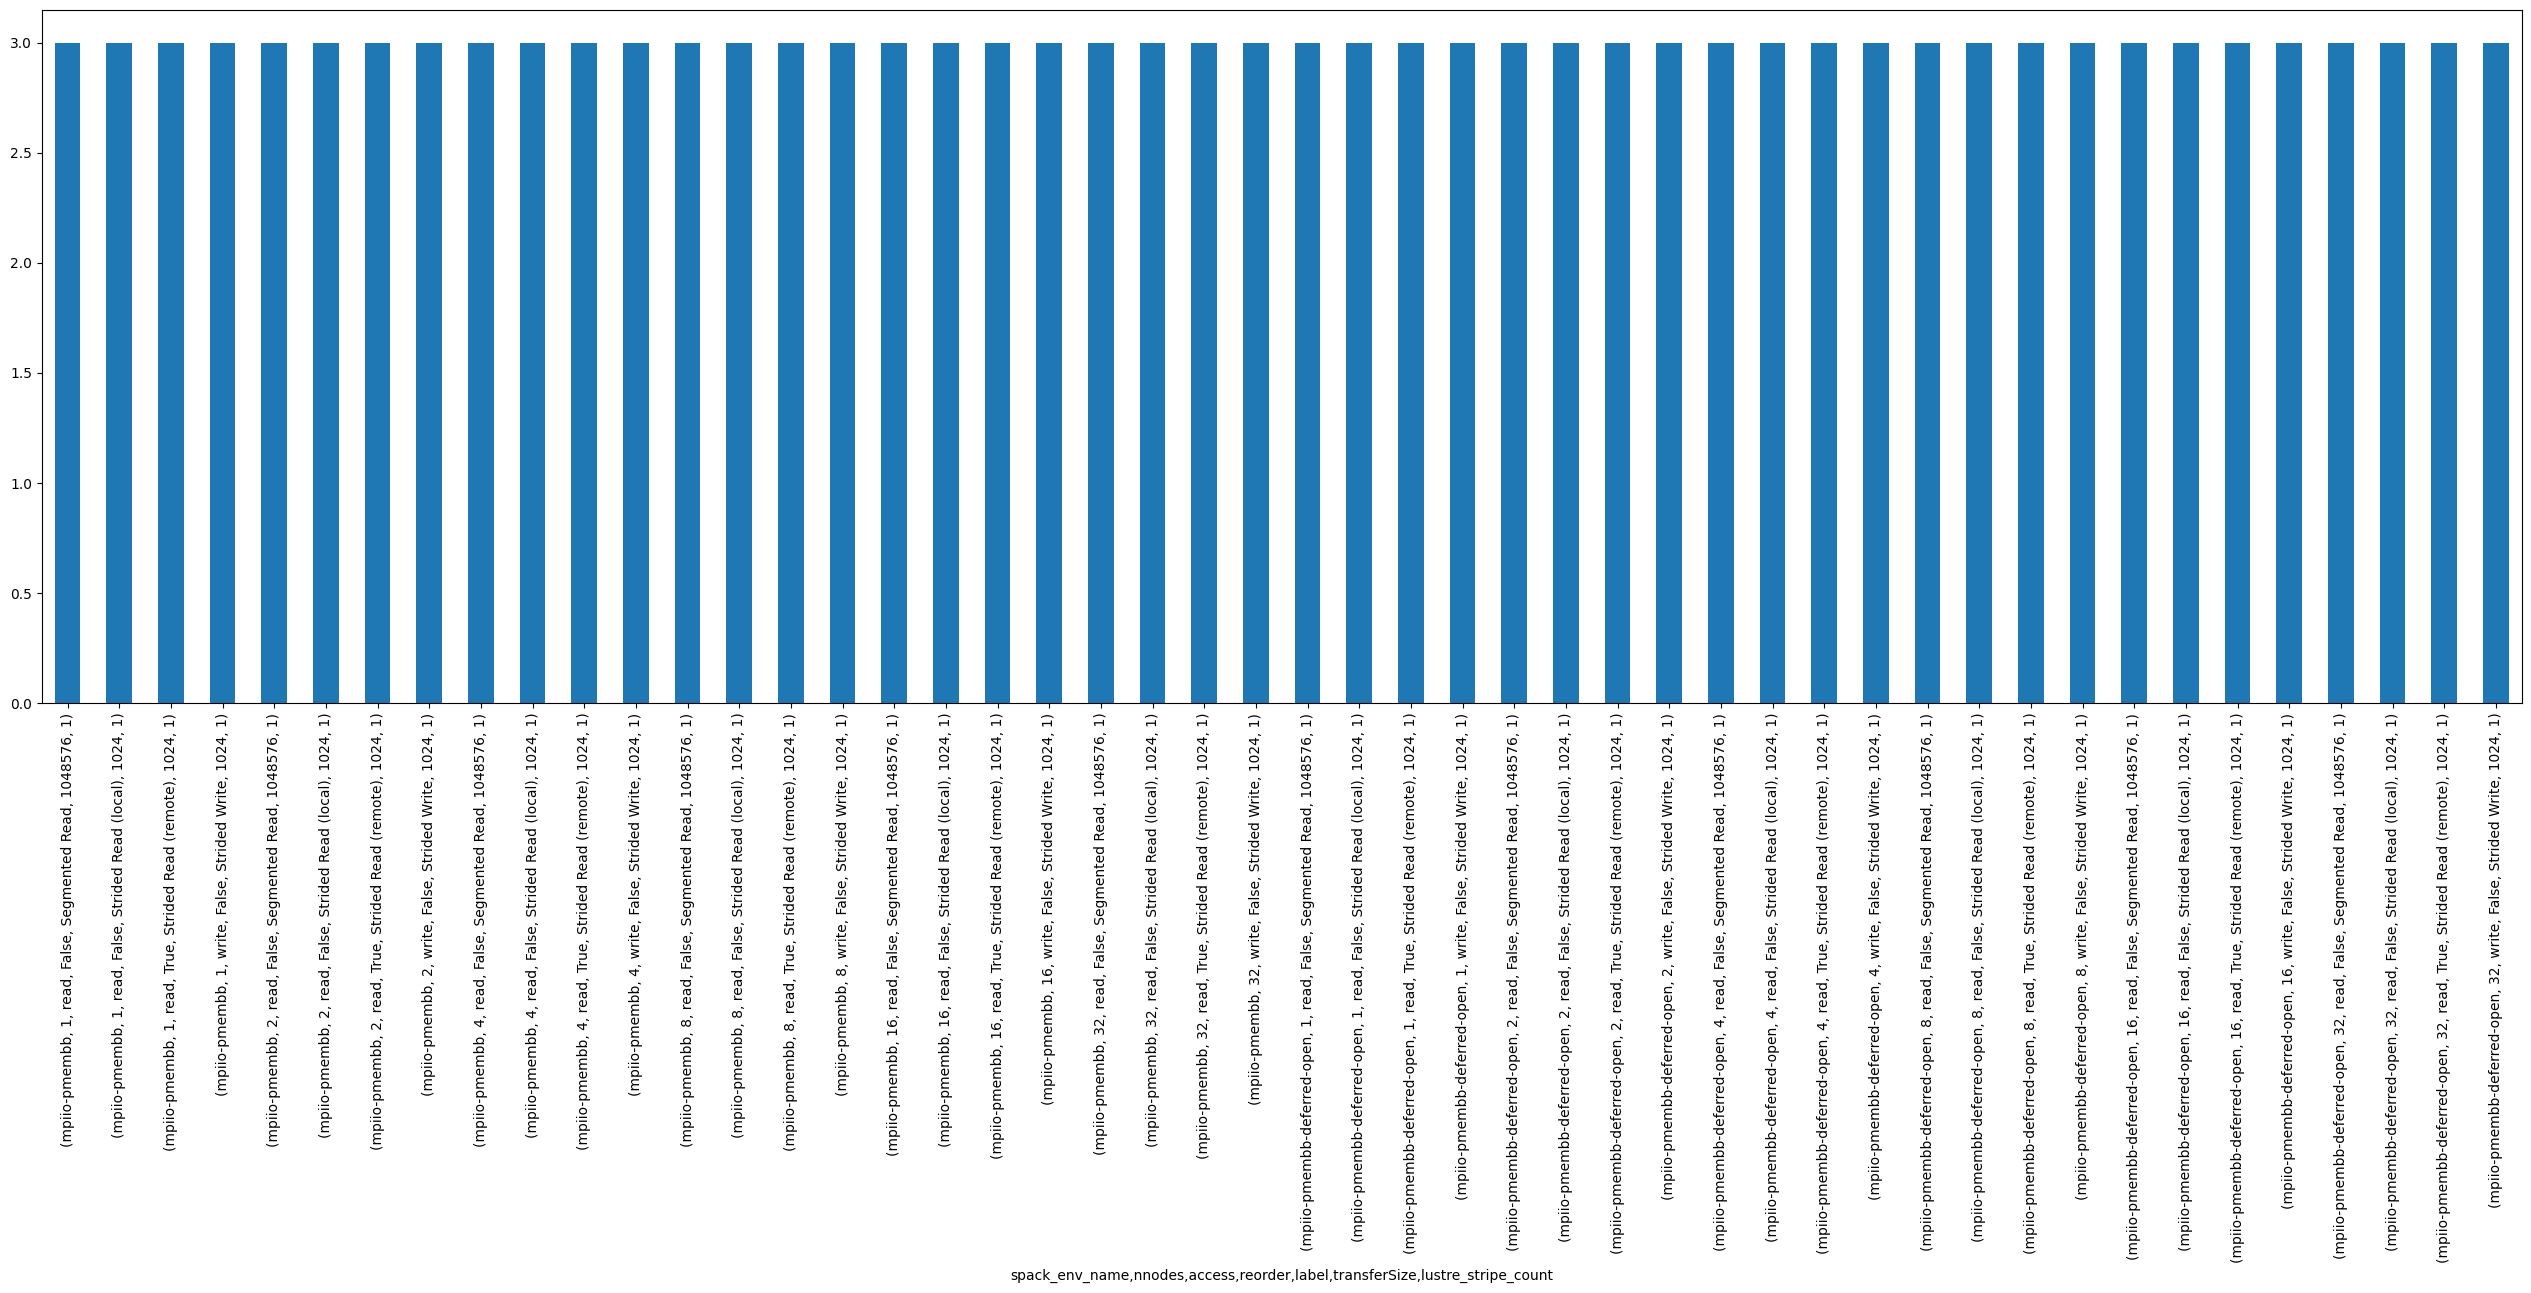

In [6]:
df = df_src
same_setting_columns = [
    "spack_env_name", "nnodes", "access", "reorder", "label", "transferSize", "lustre_stripe_count"]
same_setting_grouper = df.groupby(same_setting_columns)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# display(same_setting_grouper.size())
(
    same_setting_grouper
    .size()
    .plot(figsize=(32, 9), kind="bar")
)


In [7]:
env_to_label = {
  "mpiio-pmembb": "+aggregate_read",
  "mpiio-pmembb-deferred-open": "baseline",
  "mpiio-pmembb-agg-read": "+aggregate_read",
  "mpiio-pmembb-no-optim": "baseline",
  "mpiio-pmembb-profile": "+aggregate_read"
}

time_columns = ["openTime", "wrRdTime", "closeTime", "totalTime", "createTime", "loadTime", "saveTime", "freeTime"]

df = (
    same_setting_grouper
    [time_columns]
    .max()
    .reset_index()
    .assign(transferSizeH=lambda x: x["transferSize"].apply(pretty_fmt))
    .assign(optim=lambda x: x["spack_env_name"].apply(lambda y: env_to_label[y]))
    .query(f"lustre_stripe_count != 1")
    .query(f"not (access == 'read' and reorder == True and nnodes == 1) and not (access == 'read' and reorder == False) and transferSize == {2**20} and nnodes <= 64")
    .fillna(0.)
)
# df

for timec in time_columns:
    df[f"{timec}MS"] = df[timec] * 1000

for (access, ), df_access in df.groupby(["access"]):
    print(access)
    # if access == "write":
        # time_values = ["createTime", "openTime", "wrRdTime", "closeTime", "saveTime", "freeTime"]
        # time_values = ["loadTime", "openTime", "wrRdTime", "closeTime", "saveTime"]
    # else:
        # time_values = ["createTime", "loadTime", "openTime", "wrRdTime", "closeTime", "freeTime"]
        # time_values = ["loadTime", "openTime", "wrRdTime", "closeTime", "saveTime"]
    time_values = ["openTimeMS"]

    fig, axs = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
    fig.patch.set_alpha(1)
    fig.subplots_adjust(hspace=0, wspace=0)

    for idx, ((optim, ), df_sub) in enumerate(df_access.groupby(["optim"])):
        # display(df_sub)
        df_plot = (
            df_sub
            .set_index("nnodes")
            [time_values]
            # .loc[["baseline", "+deferred_open"], :]
        )
        display(optim, df_plot)

        # fig = plt.figure(figsize=(8, 6), dpi=100)
        # fig.patch.set_alpha(1)
        ax = df_plot.plot(
            ax=axs[(idx+1)%2],
            kind="bar",
            stacked=True,
            xlabel="",
            ylabel="IOR Open Time [ms]",
            # style=".-",
            legend=None,
            rot=0,
            width=0.8,
        )
        ax.set_title(f"{optim}")
        ax.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)
        # handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
        # ax.legend(title='nnodes', handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示
        # ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))


    # handles, labels = ax.get_legend_handles_labels()
    # fig.legend(handles=handles[::-1], labels=labels[::-1], loc="upper right", bbox_to_anchor=(0.99, 0.89))#, borderaxespad=0.)
    
    fig.text(0.5, 0.04, "Number of Nodes", ha="center", va="center")

    fig.show()
    plt.show()
    save(fig, F"ior_deffered_open_{access}")

read False Segmented Read


optim,baseline,+aggregate_read
nnodes,,
1,24.988658,25.424868
2,7.008491,37.698126
4,9.472655,59.213728
8,15.947570,121.758450
16,29.448009,249.244525
32,56.410595,459.697631


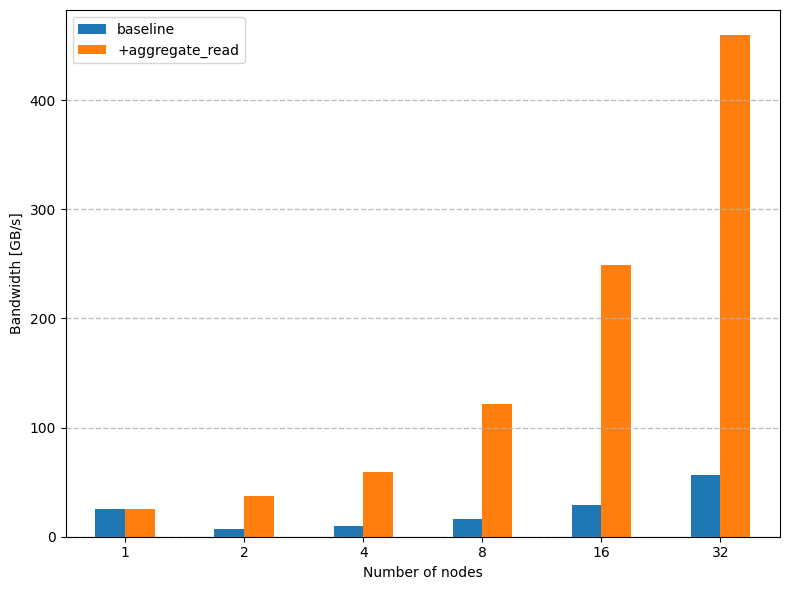

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


read False Strided Read (local)


optim,baseline,+aggregate_read
nnodes,,
1,12.252537,11.540542
2,19.776220,19.485895
4,33.227336,32.941634
8,58.445432,55.814379
16,98.369848,95.670138
32,144.873941,145.725694


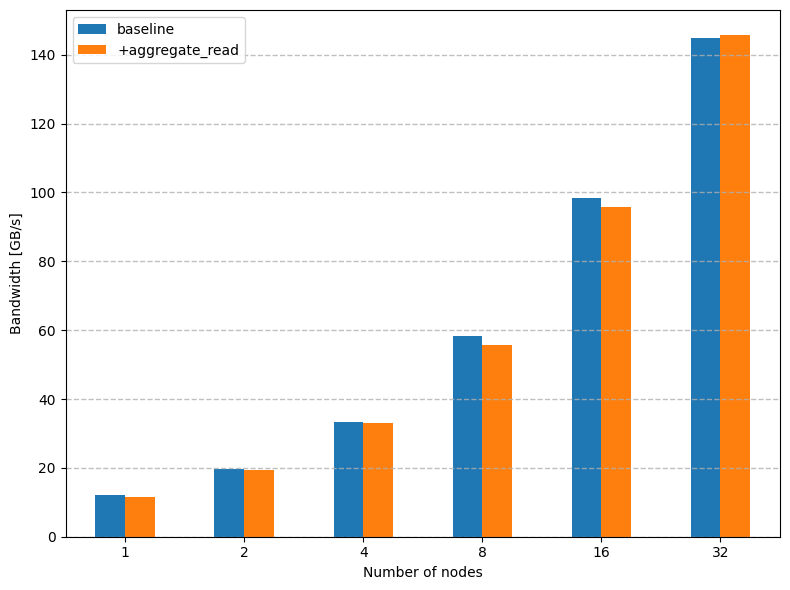

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


read True Strided Read (remote)


optim,baseline,+aggregate_read
nnodes,,
2,3.426429,3.446553
4,6.497630,6.580631
8,12.154664,12.610315
16,21.984050,23.485497
32,41.360785,41.087142


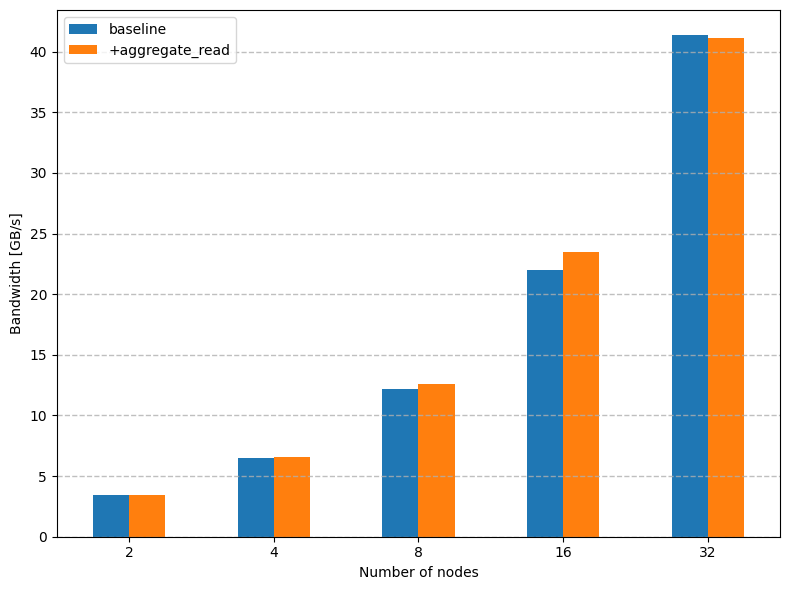

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


write False Strided Write


optim,baseline,+aggregate_read
nnodes,,
1,17.260348,17.314549
2,34.631517,34.541518
4,68.454893,68.239813
8,134.224097,133.726090
16,264.159069,264.353674
32,515.463592,515.214205


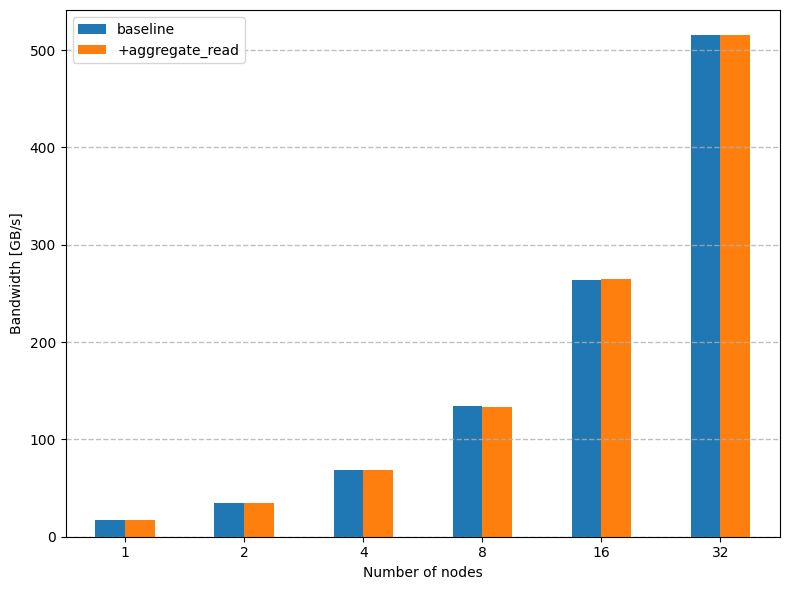

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [9]:
env_to_label = {
  "mpiio-pmembb": "+aggregate_read",
  "mpiio-pmembb-deferred-open": "baseline",
  "mpiio-pmembb-agg-read": "+aggregate_read",
  "mpiio-pmembb-no-optim": "baseline",
  "mpiio-pmembb-profile": "+aggregate_read"
}
df = (
    same_setting_grouper["bwGB"].max()
    # .agg({
    #     "bw": "max",
    #     "time": "min",
    # })
    .reset_index()
    # .assign(bwGB=lambda x: x["bw"] * 2**20 / 10**9)
    .assign(transferSizeH=lambda x: x["transferSize"].apply(pretty_fmt))
    .assign(optim=lambda x: x["spack_env_name"].apply(lambda y: env_to_label[y]))
    .query("lustre_stripe_count == 1")
    # .query("spack_env_name == 'mpiio-pmembb'")
    .query("not (access == 'read' and reorder == True and nnodes == 1)")
)

# display(df)

for (access, reorder, label), df_sub, in df.groupby(["access", "reorder", "label"]):
    print(access, reorder, label)
    # display(df_sub)
    # for value in ["bw", "time"]:
    for value in ["bwGB"]:
        # df_plot = df_sub.pivot(index="transferSize", columns=["nnodes"], values=value)
        df_plot = df_sub.pivot(index="nnodes", columns=["optim"], values=value).loc[:, ["baseline", "+aggregate_read"]]
        # df_plot = df_sub.set_index("nnodes")[value]

        display(df_plot)

        fig = plt.figure(figsize=(8, 6), dpi=100)
        fig.patch.set_alpha(1)

        ax = df_plot.plot(
            ax=fig.add_subplot(),
            kind="bar",
            # kind="line",
            # xlabel="Transfer size [B]",
            xlabel="Number of nodes",
            ylabel="Bandwidth [GB/s]" if value == "bwGB" else "Elapsed time [sec]",
            # style=".-",
            rot=0,
        )
        # ax.set_title(f"IOR {label}")
        # ax.set_xscale("log", base=2)
        # ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
        ax.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)
        # handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
        # ax.legend(title='nnodes', handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示
        ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))

        # legend_title = ax.get_legend().get_title().get_text()
        # ax.legend(title=legend_title, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
        ax.legend(title="")
        plt.tight_layout()

        fig.show()
        plt.show()
        save(fig, F"ior_{access}_{'remote' if reorder else 'local'}_{value}")
